```{admonition} Lecture Materials
:class: tip
[Download the slide deck for this lecture](/_static/pdf/Lecture16-PartialDifferentialEquations-2.pdf)
```

# Initial value problem: Heat equation

In most cases we are studying the time evolution of a certain profile $u(t,\mathbf{x})$.
In this case PDEs describe the time evolution of the field(s) starting from some initial conditions and obeying boundary conditions.

Let us take the heat equation as an example.
The field $u$ is the temperature $T$.
In one dimension the heat equation reads

$$
\frac{\partial u}{\partial t} = D \, \frac{\partial^2 u}{\partial x^2},
$$

where $D$ is the thermal diffusivity constant.

This equation describes the time evolution of $u(t,x)$ given initial profile

$$
u(t=0,x) = u_0(x),
$$

and boundary conditions
\begin{align*}
u(t,x=0) & = u_{\rm left}(t), \\
u(t,x=L) & = u_{\rm right}(t).
\end{align*}

If $u_{\rm left}(t)$ and $u_{\rm right}(t)$ are time-independent, we know that the solution will approach a stationary profile as $t \to \infty$.

## FTCS scheme

FTCS (Finite Time Centered Space) scheme is the simplest method for solving the heat equation

First we discretize the spatial coordinate into a grid with $N + 1$ points, i.e.

$$
x_k = a k, \qquad k = 0\ldots N, \qquad a = L/N,
$$

and approximate the derivative $\partial^2 u / \partial x^2$ by the lowest order central difference

$$
\frac{\partial^2 u(t,x)}{\partial x^2} \approx \frac{u(t,x+a) - 2u(t,x) + u(t,x-a)}{a^2}.
$$

To evaluate the time evolution we will work with small time steps of size $h$.
The time derivative is approximated by the forward difference

$$
\frac{\partial u(t,x)}{\partial t} \approx \frac{u(t+h,x) - u(t,x)}{h}.
$$

This gives the following discretized equation

$$
\frac{u(t+h,x) - u(t,x)}{h} = D \frac{u(t,x+a) - 2u(t,x) + u(t,x-a)}{a^2}.
$$

The method is explicit: to evaluate $u(t+h,x)$ at the next time step we only need to know $u(t,x)$ profile at the present time step.
Denoting the discretized time variable by superscript $n$ (such that $t_n = hn$) and the spatial variable by subscript $k$ (such that $x_k = ak$) we get the following iterative procedure

$$
u^{n+1}_k = u^n_k + r \, (u^n_{k+1} - 2u^n_k + u^n_{k-1}), \qquad k = 1 \ldots N-1.
$$

Here

$$
r \equiv \frac{Dh}{a^2}
$$

is a dimensionless parameter.

### Implementation of the FTCS scheme

Let us implement the FTCS scheme in Python

In [1]:
import numpy as np

# Single iteration of the FTCS scheme in the time direction
# r = Dh/a^2 is the dimensionless parameter
def heat_FTCS_iteration(u, r):
    N = len(u) - 1
    
    unew = np.empty_like(u)
    
    # Boundary conditions
    unew[0] = u[0]
    unew[N] = u[N]
    
    
    # FTCS scheme
    for i in range(1,N):
        unew[i] = u[i] + r * (u[i+1] - 2 * u[i] + u[i-1])
        
    return unew


# Perform nsteps FTCS time iterations for the heat equation
# u0: the initial profile
# h: the size of the time step
# nsteps: number of time steps
# a: the spatial cell size
# D: the diffusion constant
def heat_FTCS_solve(u0, h, nsteps, a, D = 1.):
    u = u0.copy()
    r = h * D / a**2
    for i in range(nsteps):
        u = heat_FTCS_iteration(u, r)
        
    return u

### Example

Let us consider the following problem: Example 9.3 from M. Newman, *Computational Physics*:

We have a 1 cm long steel container, initially at a temperature 20&deg; C.
It is placed in bath of cold water at 0&deg; C and filled on top with hot water at 50&deg; C.
Our goal is to calculate the temperature profile as function of time.
The thermal diffusivity constant for stainless steel is $D = 4.25 \cdot 10^{-6}$ m$^2$ s$^{-1}$.

We will calculate the profile at times $t = 0.01$ s, $0.1$ s, $0.4$ s, $1$ s, and $10$ s.

Solving the heat equation with FTCS scheme
r = h*D/a^2 = 0.0425


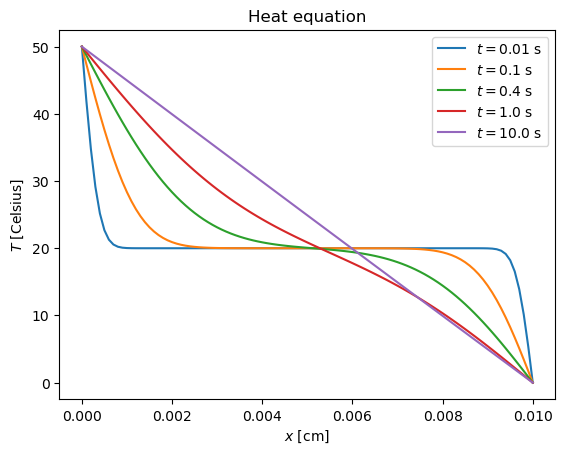

CPU times: user 4.3 s, sys: 2.25 s, total: 6.55 s
Wall time: 3.93 s


In [2]:
%%time

# Constants
L = 0.01      # Thickness of steel in meters
D = 4.25e-6   # Thermal diffusivity
N = 100       # Number of divisions in grid
a = L/N       # Grid spacing
h = 1e-4      # Time-step (in s)

print("Solving the heat equation with FTCS scheme")
print("r = h*D/a^2 =",h*D/a**2)

Tlo  = 0.0     # Low temperature in Celsius
Tmid = 20.0    # Intermediate temperature in Celsius
Thi  = 50.0    # High temperature in Celsius

# Initialize
u = np.zeros([N+1],float)
# Initial temperature
u[1:N] = Tmid
# Boundary conditions
u[0] = Thi
u[N] = Tlo

# For the output
times    = [ 0.01, 0.1, 0.4, 1.0, 10.0 ]
profiles = []
xk       = [k*a for k in range(0,N+1)]

current_time = 0.
for time in times:
    nsteps = round((time - current_time)/h)
    u = heat_FTCS_solve(u, h, nsteps, a, D)
    profiles.append(u.copy())
    current_time = time
    
# Plot the results
import matplotlib.pyplot as plt

plt.title("Heat equation")
plt.xlabel('${x}$ [cm]')
plt.ylabel('${T}$ [Celsius]')
for i in range(len(times)):
    plt.plot(xk,profiles[i],label="${t=}$" + str(times[i]) + " s")
plt.legend()
plt.show()

### Convergence and stability

Try a larger time step such that $r > 1/2$

Solving the heat equation with FTCS scheme
r = h*D/a^2 = 0.5099999999999999


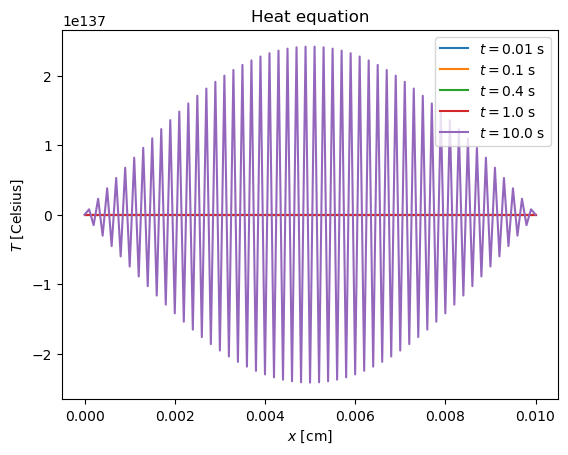

CPU times: user 818 ms, sys: 10.5 ms, total: 829 ms
Wall time: 398 ms


In [3]:
%%time

# Constants
L = 0.01      # Thickness of steel in meters
D = 4.25e-6   # Thermal diffusivity
N = 100       # Number of divisions in grid
a = L/N       # Grid spacing
h = 1.2e-3      # Time-step (in s)

print("Solving the heat equation with FTCS scheme")
print("r = h*D/a^2 =",h*D/a**2)

Tlo  = 0.0     # Low temperature in Celsius
Tmid = 20.0    # Intermediate temperature in Celsius
Thi  = 50.0    # High temperature in Celsius

# Initialize
u = np.zeros([N+1],float)
# Initial temperature
u[1:N] = Tmid
# Boundary conditions
u[0] = Thi
u[N] = Tlo

# For the output
times    = [ 0.01, 0.1, 0.4, 1.0, 10.0 ]
profiles = []
xk       = [k*a for k in range(0,N+1)]

current_time = 0.
for time in times:
    nsteps = round((time - current_time)/h)
    u = heat_FTCS_solve(u, h, nsteps, a, D)
    profiles.append(u.copy())
    current_time = time
    
plt.title("Heat equation")
plt.xlabel('${x}$ [cm]')
plt.ylabel('${T}$ [Celsius]')
for i in range(len(times)):
    plt.plot(xk,profiles[i],label="${t=}$" + str(times[i]) + " s")
plt.legend()
plt.show()

The method has become unstable.
What if we increase the spatial size step to bring $r$ back below 1/2?

Solving the heat equation with FTCS scheme
r = h*D/a^2 = 0.41309999999999986


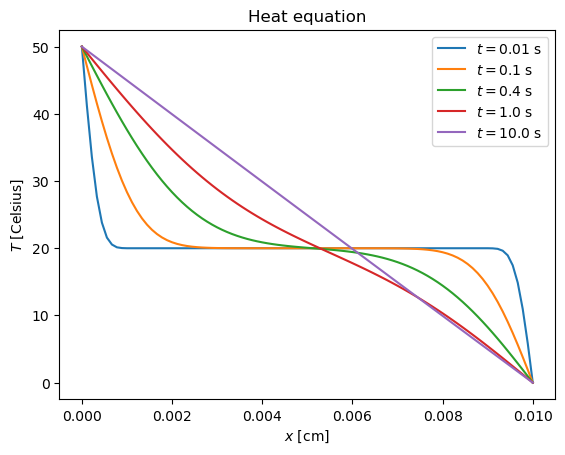

CPU times: user 837 ms, sys: 10.6 ms, total: 848 ms
Wall time: 344 ms


In [4]:
%%time

# Constants
L = 0.01      # Thickness of steel in meters
D = 4.25e-6   # Thermal diffusivity
N = 90        # Number of divisions in grid
a = L/N       # Grid spacing
h = 1.2e-3    # Time-step (in s)

print("Solving the heat equation with FTCS scheme")
print("r = h*D/a^2 =",h*D/a**2)

Tlo  = 0.0     # Low temperature in Celsius
Tmid = 20.0    # Intermediate temperature in Celsius
Thi  = 50.0    # High temperature in Celsius

# Initialize
u = np.zeros([N+1],float)
# Initial temperature
u[1:N] = Tmid
# Boundary conditions
u[0] = Thi
u[N] = Tlo

# For the output
times    = [ 0.01, 0.1, 0.4, 1.0, 10.0 ]
profiles = []
xk       = [k*a for k in range(0,N+1)]

current_time = 0.
for time in times:
    nsteps = round((time - current_time)/h)
    u = heat_FTCS_solve(u, h, nsteps, a, D)
    profiles.append(u.copy())
    current_time = time
    
plt.title("Heat equation")
plt.xlabel('${x}$ [cm]')
plt.ylabel('${T}$ [Celsius]')
for i in range(len(times)):
    plt.plot(xk,profiles[i],label="${t=}$" + str(times[i]) + " s")
plt.legend()
plt.show()

For $r < 1/2$ the method is stable again.

This underlines the importance of the stability condition for explicit methods.
Depending on the relation between time and space steps, we can either have a stable or unstable method.
For heat equation the stability condition is 
$$
r = \frac{\Delta t D}{\Delta x^2} < 1/2
$$

## Implicit scheme

In the implicit scheme one uses backward difference for the time derivative.
This implies

$$
\frac{\partial u(t+h,x)}{\partial t} \approx \frac{u(t+h,x) - u(t,x)}{h},
$$

thus

$$
\frac{u(t+h,x) - u(t,x)}{h} = D \frac{u(t+h,x+a) - 2u(t+h,x) + u(t+h,x-a)}{a^2}.
$$

In discretized notation

$$
u^{n+1}_k = u^n_k + r \, (u^{n+1}_{k+1} - 2u^{n+1}_k + u^{n+1}_{k-1}), \qquad k = 1 \ldots N-1.
$$

In other words, we have a system of linear equations for $u^{n+1}_i$:

$$
-r u^{n+1}_{k-1} + (1+2r) u^{n+1}_{k} - r u^{n+1}_{k+1} = u^n_k, \qquad k = 1 \ldots N-1.
$$

The system should be solved at each time step. Luckily, the system is tridiagonal, so it is solved in linear time.

In [5]:
import numpy as np

# Solve tridiagonal system of linear equations
#  d: vector of diagonal elements
#  l: vector of elements on the lower subdiagonal
#  u: vector of elements on the upper superdiagonal
# v0: right-hand-side vector
def linsolve_tridiagonal(d, l, u, v0):
    # Initialization
    N = len(v0)
    a = d.copy() # Current diagonal elements
    b = u.copy() # Current upper diagonal elements
    v = v0.copy()
    
    # Gaussian elimination
    for r in range(N):
        if (a[r] == 0.):
            print("Diagonal element is zero! Cannot solve the tridiagonal system with simple Gaussian elimination")
            return None
        b[r] /= a[r]
        v[r] /= a[r]
        a[r] = 1.
        if (r < N - 1):
            a[r + 1] -= l[r+1] * b[r]
            v[r + 1] -= l[r+1] * v[r]
            
    # Backsubstitution
    x = np.empty(N,float)
    
    x[N - 1] = v[N - 1]
    for r in range(N-2,-1,-1):
        x[r] = v[r] - b[r] * x[r + 1]
            
    return x

### Implementation

In [6]:
import numpy as np

# Single iteration of the implicit scheme in the time direction
# The new field is written into unew
# r = Dh/a^2 is the dimensionless parameter
def heat_implicit_iteration(u, r):
    N = len(u) - 1
    
    unew = np.empty_like(u)
    
    # Boundary conditions
    unew[0] = u[0]
    unew[N] = u[N]
    
    d  = np.full(N-1, 1+2.*r)
    ud = np.full(N-1, -r)
    ld = np.full(N-1, -r)
    v  = np.array(u[1:N])
    v[0]   += r * u[0]
    v[N-2] += r * u[N]
    
    unew[1:N] = linsolve_tridiagonal(d,ld,ud,v)
    
    return unew


# Perform nsteps implicit time iterations for the heat equation
# u0: the initial profile
# h: the size of the time step
# nsteps: number of time steps
# a: the spatial cell size
# D: the diffusion constant
def heat_implicit_solve(u0, h, nsteps, a, D = 1.):
    u = u0.copy()
    r = h * D / a**2
    # print("Heat equation with r =", r)
    for i in range(nsteps):
        u = heat_implicit_iteration(u, r)
        
    return u

Solving the heat equation with implicit scheme
r = h*D/a^2 = 4.25


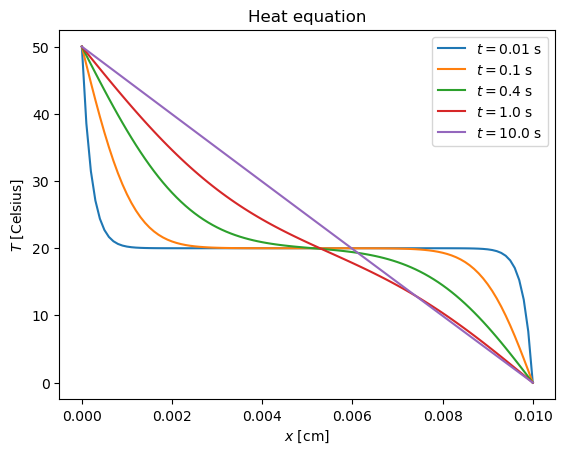

CPU times: user 571 ms, sys: 16 ms, total: 587 ms
Wall time: 201 ms


In [7]:
%%time

# Constants
L = 0.01      # Thickness of steel in meters
D = 4.25e-6   # Thermal diffusivity
N = 100       # Number of divisions in grid
a = L/N       # Grid spacing
h = 1e-2      # Time-step (in s)

print("Solving the heat equation with implicit scheme")
print("r = h*D/a^2 =",h*D/a**2)

Tlo  = 0.0     # Low temperature in Celsius
Tmid = 20.0    # Intermediate temperature in Celsius
Thi  = 50.0    # High temperature in Celsius

# Initialize
u = np.zeros([N+1],float)
# Initial temperature
u[1:N] = Tmid
# Boundary conditions
u[0] = Thi
u[N] = Tlo

# For the output
times    = [ 0.01, 0.1, 0.4, 1.0, 10.0 ]
profiles = []
xk       = [k*a for k in range(0,N+1)]

current_time = 0.
for time in times:
    nsteps = round((time - current_time)/h)
    u = heat_implicit_solve(u, h, nsteps, a, D)
    # u = heat_FTCS_solve(u, h, nsteps, a, D)
    profiles.append(u.copy())
    current_time = time
    
plt.title("Heat equation")
plt.xlabel('${x}$ [cm]')
plt.ylabel('${T}$ [Celsius]')
for i in range(len(times)):
    plt.plot(xk,profiles[i],label="${t=}$" + str(times[i]) + " s")
plt.legend()
plt.show()

Animate

![](heat_equation_1D.gif)

In [8]:
%%time

from matplotlib.animation import FuncAnimation

# Constants
L = 0.01      # Thickness of steel in meters
D = 4.25e-6   # Thermal diffusivity
N = 100       # Number of divisions in grid
a = L/N       # Grid spacing
h = 1e-3      # Time-step (in s)

print("Solving the heat equation with implicit scheme")
print("r = h*D/a^2 =",h*D/a**2)

Tlo  = 0.0     # Low temperature in Celsius
Tmid = 20.0    # Intermediate temperature in Celsius
Thi  = 50.0    # High temperature in Celsius

# Initialize
u = np.zeros([N+1],float)
# Initial temperature
u[1:N] = Tmid
# Boundary conditions
u[0] = Thi
u[N] = Tlo

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(7, 5, forward=True)
fig.suptitle("Heat equation", fontsize = 18)
current_time = 0

ax.set_xlabel('${x}$ [cm]')
ax.set_ylabel('${T}$ [Celsius]')
line = ax.plot(xk,u,label="${t=}$" + "{:.3f}".format(current_time) + " s")[0]

def animate_heat_equation_1D(i):
    # ax.clear()
    global fps
    niters = round((0.1/fps)/h)
    global u, current_time
    u = heat_implicit_solve(u, h, niters, a, D)
    current_time += h * niters
    line.set_ydata(u)
    L = ax.legend()
    L.get_texts()[0].set_text('${t=}$' + "{:.3f}".format(current_time) + " s")
    return [line, L]

fps = 30
tend = 2.
ani = FuncAnimation(fig, animate_heat_equation_1D, frames=fps * round(tend) * 10, interval=1000/fps, repeat=False)
plt.close()

from IPython.display import HTML
# HTML(ani.to_jshtml())

Solving the heat equation with implicit scheme
r = h*D/a^2 = 0.425
CPU times: user 12.6 ms, sys: 1.02 ms, total: 13.6 ms
Wall time: 4.77 ms


## Crank-Nicolson scheme

Crank-Nicolson method is a combination of FTCS and implicit schemes.
Essentially it corresponds to approximating the time derivative as average of explicit and implicit methods

$$
\frac{\partial u(t,x)}{\partial t} \approx \frac{1}{2} \left[ D \, \frac{\partial^2 u(t+h,x)}{\partial x^2} + D \, \frac{\partial^2 u(t,x)}{\partial x^2} \right].
$$

Applying central differences to the spatial derivatives we obtain

$$
\frac{u(t+h,x) - u(t,x)}{h} = \frac{D}{2} \frac{u(t+h,x+a) - 2u(t+h,x) + u(t+h,x-a)}{a^2} + \frac{D}{2} \frac{u(t,x+a) - 2u(t,x) + u(t,x-a)}{a^2}.
$$

This corresponds to the following tri-diagonal system of linear equations

$$
-r u^{n+1}_{k-1} + 2(1+r) u^{n+1}_{k} - r u^{n+1}_{k+1} = ru^n_{k-1} + 2(1-r)u^n_k + ru^n_{k+1}, \qquad k = 1 \ldots N-1.
$$

In [9]:
import numpy as np

def heat_crank_nicolson_iteration(u, r):
    N = len(u) - 1
    
    unew = np.empty_like(u)
    
    # Boundary conditions
    unew[0] = u[0]
    unew[N] = u[N]
    
    d  = np.full(N-1, 2*(1+r))
    ud = np.full(N-1, -r)
    ld = np.full(N-1, -r)
    
    # Crank-Nicolson explicit step
    v = u[1:N]*2*(1-r) + u[:-2]*r + u[2:]*r
    v[0]   += r * u[0]
    v[N-2] += r * u[N]
    
    unew[1:N] = linsolve_tridiagonal(d, ld, ud, v)
    
    return unew

def heat_crank_nicolson_solve(u0, h, nsteps, a, D = 1.):
    u = u0.copy()
    r = h * D / (a**2)
    for i in range(nsteps):
        u = heat_crank_nicolson_iteration(u, r)
        
    return u

### Implementation

Solving the heat equation with Crank-Nicolson scheme
r = h*D/a^2 = 4.25


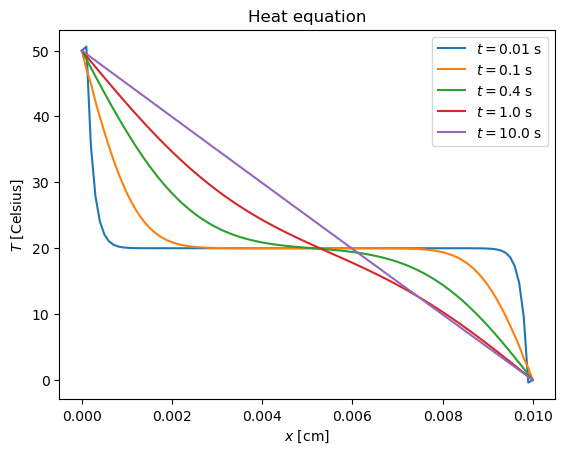

CPU times: user 568 ms, sys: 11.3 ms, total: 580 ms
Wall time: 200 ms


In [10]:
%%time

# Constants
L = 0.01      # Thickness of steel in meters
D = 4.25e-6   # Thermal diffusivity
N = 100       # Number of divisions in grid
a = L/N       # Grid spacing
h = 1e-2      # Time-step (in s)

print("Solving the heat equation with Crank-Nicolson scheme")
print("r = h*D/a^2 =",h*D/a**2)

Tlo  = 0.0     # Low temperature in Celsius
Tmid = 20.0    # Intermediate temperature in Celsius
Thi  = 50.0    # High temperature in Celsius

# Initialize
u = np.zeros([N+1],float)
# Initial temperature
u[1:N] = Tmid
# Boundary conditions
u[0] = Thi
u[N] = Tlo

# For the output
times    = [ 0.01, 0.1, 0.4, 1.0, 10.0 ]
profiles = []
xk       = [k*a for k in range(0,N+1)]

current_time = 0.
for time in times:
    nsteps = round((time - current_time)/h)
    u = heat_crank_nicolson_solve(u, h, nsteps, a, D)
    profiles.append(u.copy())
    current_time = time
    
plt.title("Heat equation")
plt.xlabel('${x}$ [cm]')
plt.ylabel('${T}$ [Celsius]')
for i in range(len(times)):
    plt.plot(xk,profiles[i],label="${t=}$" + str(times[i]) + " s")
plt.legend()
plt.show()

## Heat equation in two dimensions

In two dimensions the heat equation reads

$$
\frac{\partial u}{\partial t} = D \, \left[ \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right].
$$

This equation describes the time evolution of $u(t,x,y)$ given initial profile

$$
u(t=0,x,y) = u_0(x,y),
$$

and boundary conditions
\begin{align*}
u(t,x=0,y) & = u_{\rm left}(t;y), \\
u(t,x=L,y) & = u_{\rm right}(t;y), \\
u(t,x,y=0) & = u_{\rm bottom}(t;x), \\
u(t,x,y=L) & = u_{\rm top}(t;x).
\end{align*}

Now we have to perform discretization in both $x$ and $y$ directions.
Taking the same step size $a$ in both directions, we obtain the following discretized FTCS scheme:

$$
u^{n+1}_{i,j} = u^n_{i,j} + r \, (u^n_{i+1,j} - 2u^n_{i,j} + u^n_{i-1,j})
+ r \, (u^n_{i,j+1} - 2u^n_{i,j} + u^n_{i,j-1}), \qquad i = 1 \ldots N-1, \quad j = 1 \ldots M-1.
$$

Here, as before,

$$
r \equiv \frac{Dh}{a^2},
$$

$N = L_x/a$, $M = L_y/a$, and

$$
u^n_{i,j} = u(t + hn, a*i, a*j).
$$

Implicit and Crank-Nicholson methods are also possible, but they are a bit more involved than in 1D case.
Due to the presence of more than one dimension, the linear system to be solved at each time step is larger and does not have a simple tridiagonal form.
However, sparse matrix methods can be used to solve this system efficiently.

### Heat equation in two dimensions: FTCS implementation

In [11]:
import numpy as np

# Single iteration of the 2D FTCS scheme in the time direction
# r = Dh/a^2 is the dimensionless parameter
def heat_FTCS_iteration_2D(u, r):
    N, M = u.shape
    
    unew = np.empty_like(u)
    
    # Boundary conditions
    unew[  0, :]   = u[ 0, :]
    unew[N-1, :]   = u[N-1, :]
    unew[ :, 0]    = u[ :, 0]
    unew[ :, M-1]  = u[ :, M-1]
    
    # FTCS scheme
    for i in range(1, M-1):
        for j in range(1, N-1):
            unew[i, j] = u[i, j] + r * (u[i+1, j] - 2 * u[i, j] + u[i-1, j]) + r * (u[i, j+1] - 2 * u[i, j] + u[i, j-1])
            
    return unew

# Perform nsteps 2D FTCS time iterations for the heat equation
# u0: the initial profile
# h: the size of the time step
# nsteps: number of time steps
# a: the spatial cell size
# D: the diffusion constant
def heat_FTCS_solve_2D(u0, h, nsteps, a, D = 1.):
    u = u0.copy()
    r = h * D / a**2
    for i in range(nsteps):
        u = heat_FTCS_iteration_2D(u, r)
        
    return u


Solving the 2D heat equation with FTCS scheme
r = h*D/a^2 = 0.10625


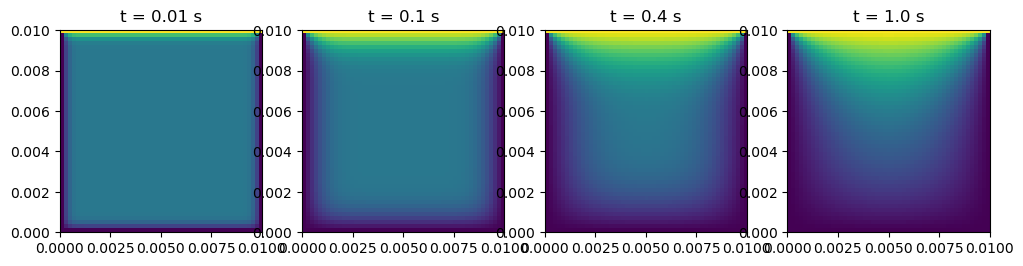

CPU times: user 2.68 s, sys: 36.8 ms, total: 2.71 s
Wall time: 2.11 s


In [12]:
%%time

# Constants
L = 0.01      # Thickness of steel in meters
D = 4.25e-6   # Thermal diffusivity
N = 50        # Number of divisions in grid
M = N
a = L/N       # Grid spacing
h = 1e-3      # Time-step (in s)

print("Solving the 2D heat equation with FTCS scheme")
print("r = h*D/a^2 =",h*D/a**2)

Tlo  = 0.0     # Low temperature in Celsius
Tmid = 20.0    # Intermediate temperature in Celsius
Thi  = 50.0    # High temperature in Celsius

# Initialize
u = np.zeros([N+1,N+1],float)
# Initial temperature
u[:,:] = Tmid
# Boundary conditions
u[0,:] = Tlo
u[N,:] = Tlo
u[:,0] = Tlo
u[:,M] = Thi

# For the output
times    = [ 0.01, 0.1, 0.4, 1.0]
profiles = []
xk       = [k*a for k in range(0,N+1)]
yk       = [k*a for k in range(0,M+1)]

current_time = 0.
for time in times:
    nsteps = round((time - current_time)/h)
    u = heat_FTCS_solve_2D(u, h, nsteps, a, D)
    profiles.append(u.copy())
    current_time = time
    
# Plot the initial and final temperature profiles
fig, ax = plt.subplots(1, len(times), figsize=(12, 5))
for i in range(len(ax)):
    ax[i].imshow(profiles[i].T, vmax=Thi, vmin=Tlo, origin="lower", extent=[0,L,0,L])
    ax[i].set_title("t = " + str(times[i]) + " s")
plt.show()

![](heat_equation_2D.gif)

In [ ]:
%%time
from IPython.display import clear_output, display
from matplotlib.animation import FuncAnimation

# Constants
L = 0.01      # Thickness of steel in meters
D = 4.25e-6   # Thermal diffusivity
N = 50        # Number of divisions in grid
M = N
a = L/N       # Grid spacing
h = 1e-3      # Time-step (in s)

print("Solving the heat equation with FTCS scheme")
print("r = h*D/a^2 =",h*D/a**2)

Tlo  = 0.0     # Low temperature in Celsius
Tmid = 20.0    # Intermediate temperature in Celsius
Thi  = 50.0    # High temperature in Celsius

# Initialize
u = np.zeros([N+1,N+1],float)
# Initial temperature
u[:,:] = Tmid
# Boundary conditions
u[0,:] = Tlo
u[N,:] = Tlo
u[:,0] = Tlo
u[:,M] = Thi


fig, ax = plt.subplots(1, 1)
fig.set_size_inches(7, 5, forward=True)
fig.suptitle("Heat equation", fontsize = 18)

im = ax.imshow(u.T, vmax=Thi, vmin=Tlo, origin="lower", extent=[0,L,0,L])
title = ax.set_title("")

current_time = 0
def animate_heat_equation(i):
    # ax.clear()
    global fps
    niters = round((0.1/fps)/h)
    global u, current_time
    u = heat_FTCS_solve_2D(u, h, niters, a, D)
    current_time += h * niters
    clear_output(wait=True)
    print("t =", current_time, "/", tend)

    im.set_data(u.T)
    title.set_text("t = " + "{:.3f}".format(current_time) + " s")
    return [im, title]

fps = 30
tend = 2.
ani = FuncAnimation(fig, animate_heat_equation, frames=fps * round(tend * 10), interval=1000/fps, repeat=False)
plt.close()
# HTML(ani.to_jshtml())

# ani.save("heat_equation_2D.gif")

# plt.close(fig)
# from IPython.display import display, Image, clear_output
# display(Image(filename="heat_equation_2D.gif"))

Solving the heat equation with FTCS scheme
r = h*D/a^2 = 0.10625
CPU times: user 17.3 ms, sys: 1.42 ms, total: 18.7 ms
Wall time: 5.44 ms


/opt/anaconda3/envs/CompPhys/lib/python3.10/site-packages/matplotlib/animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(
